# Import dependancies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bz2

import neobase as nb

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# windows file paths
#bookings_path = r'../../../data/challenge/bookings.csv.bz2'
#searches_path = r'../../../data/challenge/searches.csv.bz2'
# linux file paths
bookings_path = '../../data/challenge/bookings.csv.bz2'
searches_path = '../../data/challenge/searches.csv.bz2'

Since bookings file is 4.4Gb, we could use a sample to explore the data.

In [3]:
sample = pd.read_csv(bookings_path, compression='bz2', sep= '^', header=0, nrows = 100_000)
sample.to_csv('../../data/challenge/sample.csv', index=False)

# Explore the data available

In [4]:
sample_path = '../../data/challenge/sample.csv'
sample = pd.read_csv(sample_path)
sample.columns

Index(['act_date           ', 'source', 'pos_ctry', 'pos_iata', 'pos_oid  ',
       'rloc          ', 'cre_date           ', 'duration', 'distance',
       'dep_port', 'dep_city', 'dep_ctry', 'arr_port', 'arr_city', 'arr_ctry',
       'lst_port', 'lst_city', 'lst_ctry', 'brd_port', 'brd_city', 'brd_ctry',
       'off_port', 'off_city', 'off_ctry', 'mkt_port', 'mkt_city', 'mkt_ctry',
       'intl', 'route          ', 'carrier', 'bkg_class', 'cab_class',
       'brd_time           ', 'off_time           ', 'pax', 'year', 'month',
       'oid      '],
      dtype='object')

Some columns seem to have a indefinite amount of white spaces.

In [5]:
sample.columns = [col.strip() for col in sample.columns]
sample.columns

Index(['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc',
       'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry',
       'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry',
       'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry',
       'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier',
       'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year',
       'month', 'oid'],
      dtype='object')

We could also get rid of he spaces in some columns using loc

In [6]:
sample.loc[:,'arr_port'] = sample['arr_port'].str.strip()

Or we could rename all columns using a dictionary.

In [7]:
new_cols = {}
for col in sample.columns:
    new_cols[col] = col.strip()
sample = sample.rename(new_cols, axis=1)

# Exercise 1

Count the number of lines in python for each file

In order to do it as fast as possible we can select one column to count all lines.

bookings_lenght = len(pd.read_csv(
                                  bookings_path,
                                  compression='bz2', 
                                  sep= '^', 
                                  header=0, 
                                  usecols=['pax'], 
                                  ))
print(f'Bookings.csv has {bookings_lenght} lines.')

searches = pd.read_csv(
                       searches_path,
                       compression='bz2', 
                       sep= '^', 
                       header=0,
                       nrows=10
                       )
searches.columns

searches_lenght = len(pd.read_csv(
                                searches_path,
                                compression='bz2', 
                                sep= '^', 
                                header=0, 
                                usecols=['Date'],
                                ))
print(f'searches.csv has {searches_lenght} lines.')

# Exercise 2

Top 10 arrival airports in the world in 2013 (using the bookings file)

• Arrival airport is the column **arr_port**. It is the IATA code for the airport

• To get the total number of passengers for an airport, you can *sum* the column
**pax**, grouping by **arr_port**. Note that there is negative pax. That corresponds to
cancelations. So to get the total number of passengers that have actually
booked, you should sum including the negatives (that will remove the canceled
bookings).

• Print the top 10 arrival airports in the standard output, including the number of
passengers.

• Bonus point: Get the name of the city or airport corresponding to that airport
(programatically, we suggest to have a look at GeoBases in Github)

• Bonus point: Solve this problem using pandas (instead of any other approach)

In [8]:
df_full = pd.read_csv(
                     bookings_path,
                     compression='bz2', 
                     sep= '^', 
                     header=0, 
                     usecols=['arr_port', 'pax', 'year'], 
                     #nrows = 100000
                     chunksize=100_000 # con este parametro se convierte en un iterador
                    )

We load the dataset using chunks.

In [9]:
top_airports = []
with df_full as df_iter:
    for chunk in df_full:
        top_chunk = chunk.groupby('arr_port')['pax'].sum().reset_index().sort_values(by='pax', ascending=False)
        top_airports.append(top_chunk)

top = pd.concat(top_airports, axis= 0)

top_10_arrival = top.groupby('arr_port').sum().sort_values(by='pax', ascending=False).head(10).copy()

We loop through the data and extract the top airports by passengers. 

https://pypi.org/project/GeoBases/

In [10]:
top_10_arrival.index

Index(['LHR     ', 'MCO     ', 'LAX     ', 'LAS     ', 'JFK     ', 'CDG     ',
       'BKK     ', 'MIA     ', 'SFO     ', 'DXB     '],
      dtype='object', name='arr_port')

IATA codes are also spelled with spaces so we have to take them out before proceeding.

In [16]:
top_10_arrival.index = [ind.strip() for ind in top_10_arrival.index]

In [21]:
b = nb.NeoBase()
for i in top_10_arrival.index:
    top_10_arrival['city_name'][i] = b.get(i, 'name')

/tmp/ipykernel_7962/3583124350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_arrival['city_name'][i] = b.get(i, 'name')


In [22]:
top_10_arrival

,pax,city_name
LHR,88809.0,London Heathrow Airport
MCO,70930.0,Orlando International Airport
LAX,70530.0,Los Angeles International Airport
LAS,69630.0,McCarran International Airport
JFK,66270.0,John F. Kennedy International Airport
CDG,64490.0,Paris Charles de Gaulle Airport
BKK,59460.0,Suvarnabhumi Airport
MIA,58150.0,Miami International Airport
SFO,58000.0,San Francisco International Airport
DXB,55590.0,Dubai International Airport


# Exercise 3

Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

• For the arriving airport, you can use the
Destination column in the searches file.

• Plot a curve for Málaga, another one for
Madrid, and another one for Barcelona, in
the same figure.

• Bonus point: Solving this problem using
pandas (instead of any other approach)

In [23]:
sample_search = pd.read_csv(
                            searches_path, 
                            compression='bz2', 
                            sep= '^', 
                            usecols=['Date', 'Destination', 'Origin'],
                            header=0, 
                            nrows = 100_000

                            )

sample_search.to_csv('../../data/challenge/sample.csv', index=False)
sample_search.columns

Index(['Date', 'Origin', 'Destination'], dtype='object')

In [27]:
from datetime import datetime

sample_search['Date_new'] = pd.to_datetime(sample_search['Date']).dt.to_period('M')
sample_search.drop('Date', axis=1, inplace=True)


In [28]:
sample_search

,Origin,Destination,Date_new
0,TXL,AUH,2013-01
1,ATH,MIL,2013-01
2,ICT,SFO,2013-01
3,RNB,ARN,2013-01
4,OSL,MAD,2013-01
...,...,...,...
99995,DEL,TRV,2013-04
99996,BUF,AUA,2013-04
99997,JFK,KUL,2013-04
99998,STL,SEA,2013-04


In [71]:
df_search = pd.read_csv(
                        searches_path, 
                        compression='bz2', 
                        sep= '[,,^]', 
                        usecols=['Date', 'Destination', 'Origin'],
                        header=0, 
                        #nrows = 100_000,
                        chunksize=100_000
                        )

In [72]:
df_search

In [47]:
MBM_searches = []
df_search['Date'] = pd.to_datetime(df_search['Date'])
df_search['Date_new'] = df_search['Date'].dt.to_period('M')
df_search.drop('Date', axis=1, inplace=True)
df_search = df_search[(df_search['Destination'].isin(['MAD','BCN', 'AGP']))]
        
MBM_searches.append(df_search)

In [70]:
MBM_searches

[]

In [73]:
from datetime import datetime

MBM_searches = []

for chunk in df_search:
        chunk['Date'] = pd.to_datetime(chunk['Date'])
        chunk['Date_new'] = chunk['Date'].dt.to_period('M')
        chunk = chunk[(chunk['Destination'].isin(['MAD','BCN', 'AGP']))]
        
        MBM_searches.append(chunk)

MBM_searches_full = pd.concat(MBM_searches, axis= 0)

grouped = MBM_searches_full.groupby(['Destination', 'Date_new']).count()
grouped.drop('Date', axis=1, inplace=True)

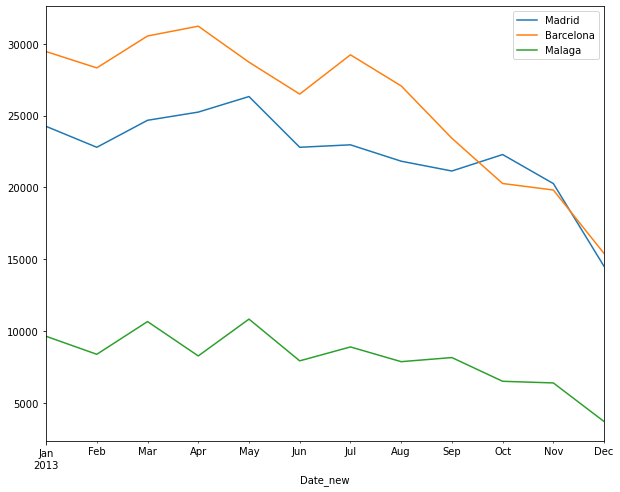

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped.loc['MAD'].plot(ax=ax, label='MAD')
grouped.loc['BCN'].plot(ax=ax).set_label('MAD')
grouped.loc['AGP'].plot(ax=ax).set_label('MAD')
plt.legend(['Madrid', 'Barcelona', 'Malaga'])
plt.show()

# Exercise 4
Match searches with bookings

• For every search in the searches file, find out whether
the search ended up in a booking or not (using the info
in the bookings file). For instance, search and booking
origin and destination should match.

• For the bookings file, origin and destination are the
columns dep_port and arr_port, respectively.

• Generate a CSV file with the search data, and an
additional field, containing 1 if the search ended up in
a booking, and 0 otherwise.

In [ ]:
# bookings --> dep port, arr port 
# searches --> Origin, Destination

# Exercise 5

Write a Web Service

• Wrap the output of the second exercise in a
web service that returns the data in JSON
format (instead of printing to the standard
output).

• The web service should accept a parameter
n>0. For the top 10 airports, n is 10. For the X
top airports, n is X 